# Running the regression model

## Workflow

### Setting dummy variables

The variables available are:
- `Year`
- `UnqID`
- `Zone`
- `Date`
- `Time`
- `Weather`
- `Path`
- `Mode`
- `Count`, which is our independent variable.



In [141]:
# import libraries

import os
from urllib.request import urlopen
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import time
import statsmodels
import statsmodels.api as sm
import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# files saved under Data/ActiveTravelCounts
dir = 'Data/ActiveTravelCounts'
count_fn = 'counts_nodummies.parquet'
point_fn = 'count_locations.geoparquet'

In [5]:
# finding out the categories

point = gpd.read_parquet(os.path.join(dir, point_fn))
count = pd.read_parquet(os.path.join(dir, count_fn))



In [18]:
point['Road type'].value_counts()

Road type
Local Street    762
A Road          582
0               330
MVF             270
Minor Road      222
B Road          131
Name: count, dtype: int64

In [99]:
# joining with the point data
count_joined = count.join(point.set_index('Site ID')[['Borough', 'Road type']], on = 'UnqID')

# Add a new column of distance with distance from centre
count_joined['zone_dummy'] = count_joined.Zone.map({'Central': 0, 'Inner': 1, 'Outer': 2}) 

# Add a new column of isdry and map it to dry: 1 and wet: 0 based on the value of the Weather column
count_joined['isdry'] = count_joined.Weather.map({'Dry': 1, 'Wet': 0})

# extracting the required columns
columns = ['UnqID', 'zone_dummy', 'isdry', 'Path', 'Mode', 'ispeak', 'Road type', 'Count']
count_df = count_joined[columns]

# filtering conventional cycles and where road type is defined
count_df = count_df[(count_df.Mode == 'Conventional cycles') & (count_df['Road type'] != 0)]

count_df.sample(10)

,UnqID,zone_dummy,isdry,Path,Mode,ispeak,Road type,Count
98160,INNCY050,1,1,Pavement,Conventional cycles,1,A Road,0
755392,INNCY466,1,1,Cycle lane,Conventional cycles,0,Local Street,0
708545,INNCY435,1,1,Pavement,Conventional cycles,0,Local Street,0
733668,INNCY451,1,1,Pavement,Conventional cycles,0,Local Street,0
401524,OUTCY233,2,1,Pavement,Conventional cycles,0,Local Street,0
119131,CSHCY091,1,1,Pavement,Conventional cycles,0,B Road,0
113229,OUTCY053,2,1,Pavement,Conventional cycles,1,A Road,0
681557,QWPCY020,2,1,Pavement,Conventional cycles,0,Local Street,0
73020,CSHCY061,1,1,Pavement,Conventional cycles,0,A Road,0
542019,OUTCY327,2,1,Carriageway,Conventional cycles,1,Local Street,1


In [131]:
# use groupby() to get the average number of cycles for every 15 minutes in each situation
count_summary = count_df.groupby(['zone_dummy', 'Road type', 'isdry', 'ispeak', 'Path']).Count.mean().dropna().reset_index()
count_summary.head(20)

/tmp/ipykernel_978/1199470087.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_summary = count_df.groupby(['zone_dummy', 'Road type', 'isdry', 'ispeak', 'Path']).Count.mean().dropna().reset_index()


,zone_dummy,Road type,isdry,ispeak,Path,Count
0,0,A Road,1,0,Bus lane,10.217361
1,0,A Road,1,0,Carriageway,9.181745
2,0,A Road,1,0,Cycle lane,15.308967
3,0,A Road,1,0,Pavement,0.221729
4,0,A Road,1,1,Bus lane,23.974240
5,0,A Road,1,1,Carriageway,22.854522
6,0,A Road,1,1,Cycle lane,46.431135
7,0,A Road,1,1,Pavement,0.271318
8,0,A Road,0,0,Bus lane,8.262411
9,0,A Road,0,0,Carriageway,6.375947


In [132]:
# get dummy variables
count_summary = pd.get_dummies(count_summary, columns = ['Path', 'Road type'], dtype = 'int')

# drop unnneccesary columns
count_summary = count_summary.drop(columns = ['Path_Cycle lane', 'Road type_Local Street'])

68.0

<Axes: >

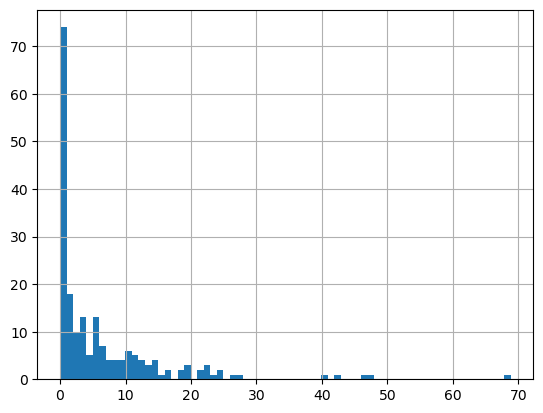

In [146]:
# plot the distribution of counts per 15 minutes
count_summary.Count.hist(bins = np.ceil(count_summary.Count.max()).astype(int))

## Doing the Advanced Regression



Text(0.5, 1.0, 'Correlation Matrix')

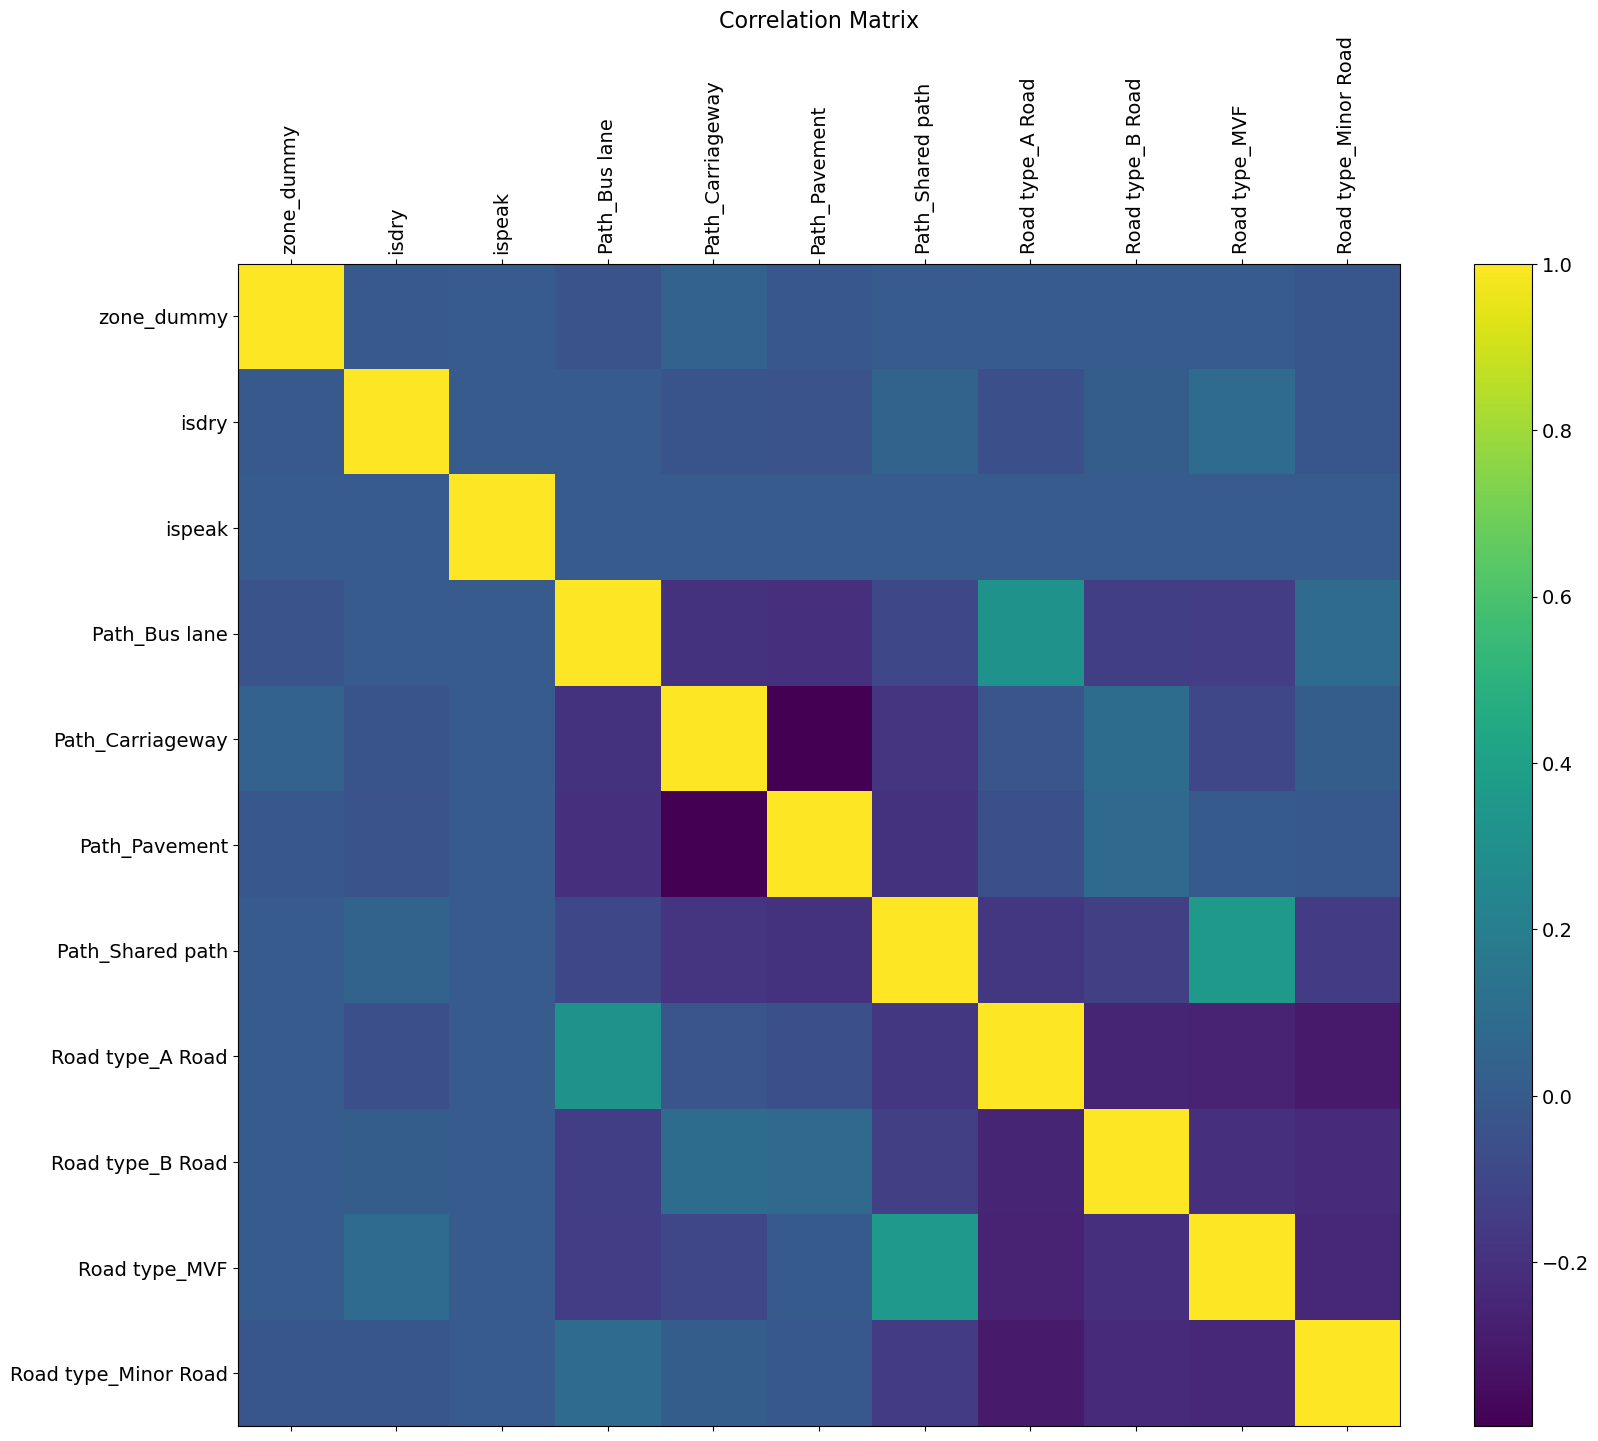

In [147]:
# check multi-colinearity
df = count_summary.copy().drop(columns = ['Count'])
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90) # rotation of xticks
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [148]:
# define function
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [149]:
print(count_summary.drop('Count', axis = 1).columns)
# using VIF on the bike_rental dataset
df_predictors_selected_VIF = drop_column_using_vif_(count_summary.drop('Count', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

Index(['zone_dummy', 'isdry', 'ispeak', 'Path_Bus lane', 'Path_Carriageway',
       'Path_Pavement', 'Path_Shared path', 'Road type_A Road',
       'Road type_B Road', 'Road type_MVF', 'Road type_Minor Road'],
      dtype='object')
The columns remaining after VIF selection are:
Index(['zone_dummy', 'isdry', 'ispeak', 'Path_Bus lane', 'Path_Carriageway',
       'Path_Pavement', 'Path_Shared path', 'Road type_A Road',
       'Road type_B Road', 'Road type_MVF', 'Road type_Minor Road'],
      dtype='object')


In [150]:
model_bike_count = sm.OLS(endog=count_summary[['Count']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_bike_count.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     11.15
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           9.62e-16
Time:                        00:43:51   Log-Likelihood:                -674.51
No. Observations:                 197   AIC:                             1373.
Df Residuals:                     185   BIC:                             1412.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.0803      1.857      5.428      0.000       6.416      13.744
zone_dummy              -4.0957      0.692     -5.916      0.000      -5.462      -2.730
isdry                    1.8938      1.105      1.713      0.088      -0.287       4.074
ispeak                   5.3376      1.092      4.888      0.000       3.183       7.492
Path_Bus lane           -3.2904      2.215     -1.485      0.139      -7.660       1.080
Path_Carriageway        -3.2889      1.503     -2.188      0.030      -6.254      -0.324
Path_Pavement          -10.3942      1.476     -7.042      0.000     -13.306      -7.482
Path_Shared path        -2.0796      2.364     -0.879      0.380      -6.744       2.585
Road type_A Road         2.7000      1.739      1.553      0.122      -0.730       6.131
Road type_B Road         2.2326      1.838      1.214      0.226      -1.394       5.860
Road type_MVF            1.4106      1.813      0.778      0.438      -2.167       4.988
Road type_Minor Road    -1.0332      1.738     -0.595      0.553      -4.461       2.395
==============================================================================
Omnibus:                      161.648   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2472.613
Skew:                           3.027   Prob(JB):                         0.00
Kurtosis:                      19.266   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Discussion

The variables that fulfill $p<0.05$ are:

- `zone_dummy`: as we go outside, the density decreases
- `ispeak`: if peak, the traffic increases
- `Path_Carriageway`: considerably less cycles on carriageway compared to cycle lane
- `Path_Pavement`: considerably less cycles on pavement (sidewalk) compared to cycle lane

On the other hand, these factors do not have significant impact:
- weather (really? $p=0.088$ suggests we are close, but still surprising)
- type of road
- bus lane / shared path

To Do: consider if these have an impact when we looked at them one by one. Maybe.


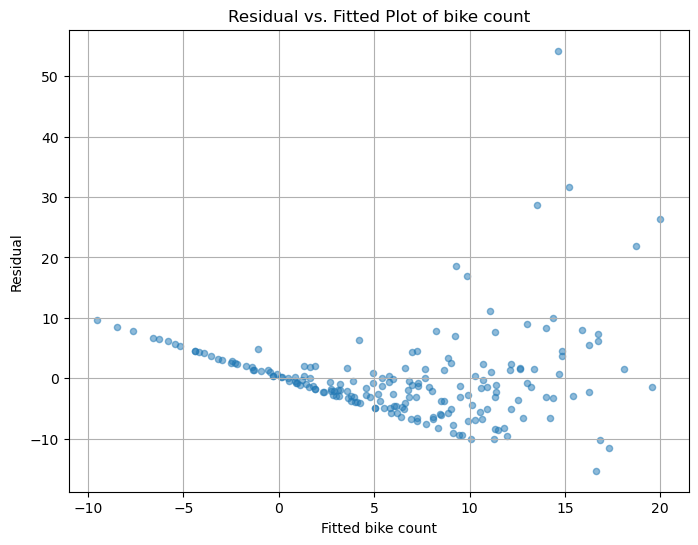

In [151]:
# residual analysis

# Set the figure size
plt.figure(figsize=(8, 6))  
# alpha = 0.5: controlling the transparency of the markers. Here alpha = 0.5 means that the markers are semi-transparent.
# s = 20: controlling the size of the markers. The default value is plt.rcParams['lines.markersize'] ** 2. Here we set it as 20.
# To get the default value of marker size, run the following line
# print(plt.rcParams['lines.markersize'] ** 2) 
plt.scatter(model_bike_count.fittedvalues, model_bike_count.resid, alpha = 0.5, s=20)
# adding title and labels
plt.xlabel('Fitted bike count')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of bike count')
# Adding grid lines
plt.grid(True)
plt.show()

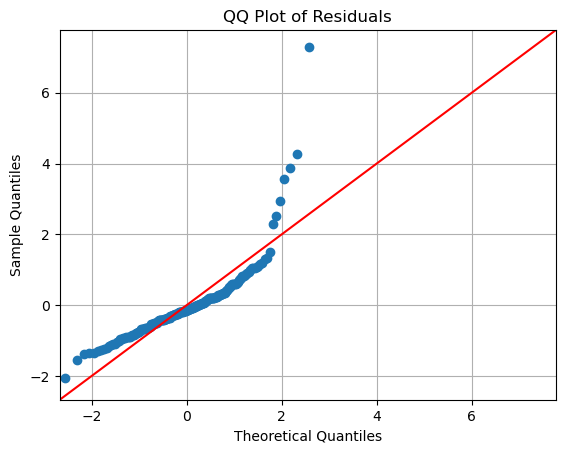

In [152]:
# (optional) the QQ plot of residuals
# More details: https://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot.html
fig = sm.qqplot(model_bike_count.resid, fit=True, line="45")
plt.title('QQ Plot of Residuals')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()